## Setup



In [2]:
!pip install --quiet poetry  # Fixes https://github.com/python-poetry/poetry/issues/532
!pip install --quiet git+https://github.com/oughtinc/ergo.git@dccf8cd526a0e7367aa1fef086f042d7eaa53aa3
!pip install --quiet plotnine

     |████████████████████████████████| 225kB 2.8MB/s 
     |████████████████████████████████| 61kB 6.7MB/s 
     |████████████████████████████████| 112kB 9.1MB/s 
     |████████████████████████████████| 61kB 6.2MB/s 
     |████████████████████████████████| 92kB 6.7MB/s 
     |████████████████████████████████| 2.7MB 8.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 522kB 2.8MB/s 
     |████████████████████████████████| 153kB 11.8MB/s 
     |████████████████████████████████| 29.5MB 109kB/s 
     |████████████████████████████████| 307kB 49.3MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 61kB 8.5MB/s 
     |████████████████████████████████| 491kB 46.6MB/s 
     |████████████████████████████████| 2.8MB 37.1MB/s 
     |████████████████████████████████| 92kB 8.9MB/s 
     |████████████████████████████████| 122kB 55.9

    ents to build wheel ... etadata ... ERROR: chainer 6.5.0 has requirement typing-extensions<=3.6.6, but you'll have typing-extensions 3.7.4.2 which is incompatible.



In [0]:
import requests
import torch
import io
import zipfile
import os
import ergo
import requests
import scipy.stats

import pandas as pd
import numpy as np

from datetime import date, datetime, timedelta
from types import SimpleNamespace
from typing import List
import plotnine
from plotnine import *

    /usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
      import pandas.util.testing as tm

Log into a Metaculus account

If running in a collab notebook, please enter your Metaculus credentials
here



In [0]:
def is_local():
  try:
    %env USER
    return True
  except:
    return False

metaculus_api = "pandemic"

if is_local():
  from dotenv import load_dotenv
  load_dotenv() 
  metaculus = ergo.Metaculus(username=os.getenv("METACULUS_USERNAME"), password=os.getenv("METACULUS_PASSWORD"), api_domain=metaculus_api)
else: 
  try:    
    
    metaculus = ergo.Metaculus(username="oughttest", password="6vCo39Mz^rrb", api_domain=metaculus_api)  
  except: 
    print(f'WARNING, You will need to enter your metaculus credentials in this cell')

## Questions



Here are the question we want to forecast:



In [3]:
question_ids = [
  3935,
  3948,
  3941,
  3939,
  3937
]
question_names = [
    "The United Kingdom",
    "France",
    "Poland",
    "The State of California",
    "Italy"
]


areas = question_names
questions = [metaculus.get_question(id, name=name) for (name, id) in zip(question_names, question_ids)]
ergo.MetaculusQuestion.to_dataframe(questions)

,id,name,title,resolve_time
0,3935,The United Kingdom,When will the current lockdown in the UK be li...,2021-09-26 22:00:00
1,3948,France,When will the current lockdown in France be li...,2021-09-26 22:00:00
2,3941,Poland,When will the current lockdown in Poland be li...,2021-09-26 22:00:00
3,3939,The State of California,When will the current lockdown in the state of...,2021-09-26 22:00:00
4,3937,Italy,When will the current lockdown in Italy be lif...,2020-04-11 15:12:00


## Assumptions and Question Information



-   intensity&#x2014;a 1-5 corresponding to the severity/degree of adherence of
    the social distancing, with 5 being the most strictly
    observed/enforced social distancing
-   re-evaluation&#x2014;date at which government said they would re-assess
    lockdown



In [0]:
Area = dict
assumptions = SimpleNamespace()

assumptions.lockdowns = {
  "New York" : {
    "data_key" : "New York",
    "question_name" : "The State of New York",
    "start": date(2020, 3, 21),
    "intensity": 3,
    "end": None #pendulum.Date(2020, X, X)
  },
  "California" : {
    "data_key" : "California",
    "question_name" : "The State of California", 
    "start": date(2020, 3, 22),
    "end": None #date(2020, X, X)
  },
  "United Kingdom": {
    "data_key" : "United Kingdom",
    "question_name" : "The United Kingdom", 
    "start": date(2020, 3, 23),
    "re_evaluated": None, 
    "intensity": 3, 
    "end": None #date(2020, X, X)
  },
  "France": {
    "data_key" : "France",
    "question_name" : "France", 
    "start": date(2020, 3, 17),
    "re_evaluated": date(2020, 4, 1),
    "intensity": 3, 
    "end": None #date(2020, X, X)
  },
  "Poland": {
    "data_key": "Poland",
    "question_name" : "Poland",
    "start": date(2020, 3, 25),
    "re_evaluated": date(2020, 4, 11),
    "end": None #date(2020, X, X)
  },
  "Italy": {
    "data_key": "Italy",
    "question_name" : "Italy",
    "start": date(2020, 3, 23),
    "end": None #date(2020, X, X)
  }
}

Helper Functions



In [0]:
#hack implementation of date.fromisoformat (is in datetime @ pyton 3.7)
def fromisoformat( xdate): 
    return datetime.strptime(xdate, '%Y-%m-%d').date()

# This allows access to the right assumptions using a question name. 
def get_assumptions(key, assumptions = assumptions.lockdowns):
  if isinstance(key, str):
    if key in assumptions:
      return assumptions[key]
    print(f"No assumptions for data key: {key}")
  elif issubclass(type(key), ergo.metaculus.MetaculusQuestion):
    for k,v in assumptions.items():
      if v['question_name'] == key.name:
        return v
    print(f"No assumptions for question: {question.name}")
  else:
      print(f"Neither a question nor a data_key was passed")   

# ripped from https://techoverflow.net/2018/01/16/downloading-reading-a-zip-file-in-memory-using-python/
def download_extract_zip(url):
    """
    Download a ZIP file and extract its contents in memory
    yields (filename, file-like object) pairs
    """
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as thezip:
        for zipinfo in thezip.infolist():
            with thezip.open(zipinfo) as thefile:
                yield zipinfo.filename, thefile

## Data



We now have predictions from
[http://www.healthdata.org/covid/data-downloads](http://www.healthdata.org/covid/data-downloads)

***TODO*** if something like this is going to persist, then consider
migrating to ergo/data/covid19.py

Get Data



In [0]:
url="https://ihmecovid19storage.blob.core.windows.net/latest/ihme-covid19.zip"

for name, xfile in download_extract_zip(url):
    if os.path.basename(name) =="Hospitalization_all_locs.csv":
        infections_df = pd.read_csv(xfile)

Clean and Enhance Data

**variable description**

-   admis_mean = daily # of admissions to hospital
-   allbed_mean = cumsum of admis_mean



In [7]:
#filter data        
infections_df = infections_df.loc[infections_df['location_name'].isin(["New York", "California", "United Kingdom", "France", "Poland",  "Italy"]),
                                  ['location_name', 'date', 'admis_mean', 'newICU_mean', 'deaths_mean', 'totdea_mean', 'allbed_mean', 'ICUbed_mean', 'bedover_mean', 'icuover_mean']]

#infections_df['location_name'].unique() 

# calculate days from lockdown
def calulate_days_from_lockdown_start(df: pd.core.frame.DataFrame):
    lockdown_start = get_assumptions(df['location_name'])['start']
    return (lockdown_start - fromisoformat(df['date'])).days

infections_df['days_from_lockdown'] = infections_df.apply(lambda x: calulate_days_from_lockdown_start(x), axis=1)

# calculate cumulative addmissions
infections_df['admis_cum'] = infections_df['admis_mean'].cumsum() 

# calculate doubling rate
infections_df['doubling_rate_in_days'] = infections_df['admis_cum'] / infections_df['admis_mean']

# calculate the new cases as a percentage of previous total
infections_df['progression'] =  infections_df['admis_cum'] / infections_df['admis_mean']
infections_df['progression'] = infections_df['progression'].apply(lambda x: min(x, 365)) # we don't care about doubling rates longer than a year (at least)

# remove all NAs
infections_df.fillna(0)

,location_name,date,admis_mean,newICU_mean,deaths_mean,totdea_mean,allbed_mean,ICUbed_mean,bedover_mean,icuover_mean,days_from_lockdown,admis_cum,doubling_rate_in_days,progression
2365,United Kingdom,2020-01-03,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,80,0.000000,0.0,0.0
2366,United Kingdom,2020-01-04,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,79,0.000000,0.0,0.0
2367,United Kingdom,2020-01-05,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,78,0.000000,0.0,0.0
2368,United Kingdom,2020-01-06,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,77,0.000000,0.0,0.0
2369,United Kingdom,2020-01-07,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,76,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26225,California,2020-07-31,0.0,0.0,0.0,1658.271,0.0,0.0,0.0,0.0,-131,457807.783895,inf,365.0
26226,California,2020-08-01,0.0,0.0,0.0,1658.271,0.0,0.0,0.0,0.0,-132,457807.783895,inf,365.0
26227,California,2020-08-02,0.0,0.0,0.0,1658.271,0.0,0.0,0.0,0.0,-133,457807.783895,inf,365.0
26228,California,2020-08-03,0.0,0.0,0.0,1658.271,0.0,0.0,0.0,0.0,-134,457807.783895,inf,365.0


## Explore Features



### Hospital Admissions



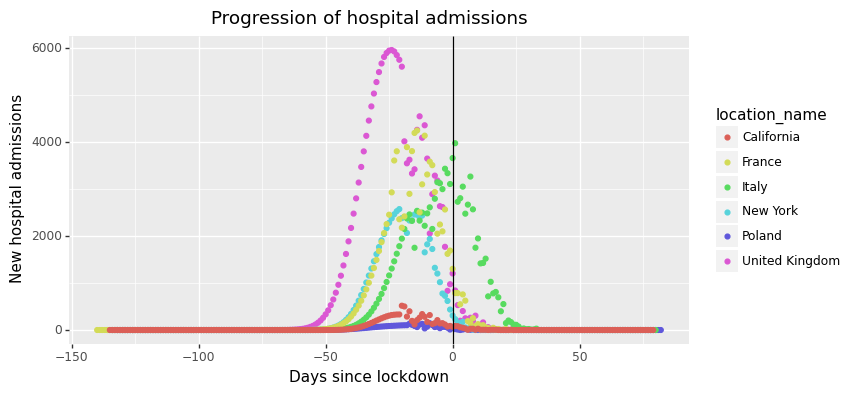

<ggplot: (325863337)>

In [8]:
plotnine.options.figure_size = (8,4)
(ggplot(infections_df, aes('days_from_lockdown', 'admis_mean', color='location_name'))
     + geom_point()
     + geom_vline(xintercept=0) 
     + labs(x='Days since lockdown',  y='New hospital admissions', title='Progression of hospital admissions')
  )

Examine the evolution of the rate of the spread of the infection



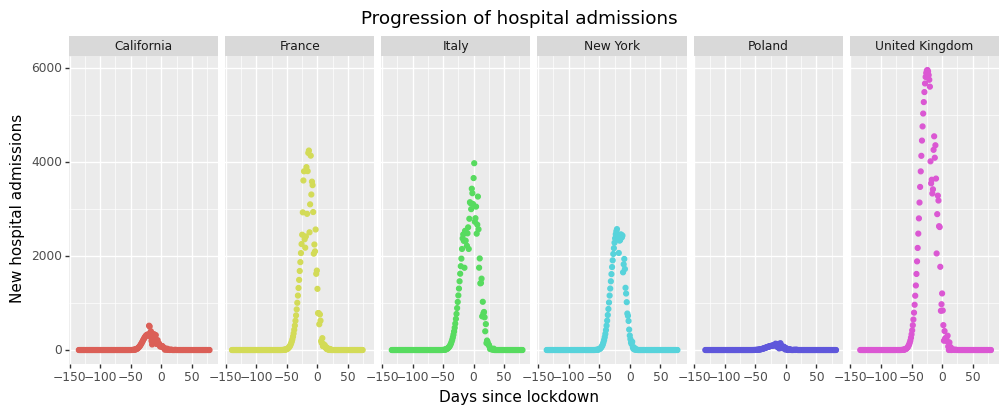

<ggplot: (-9223372036565316885)>

In [9]:
plotnine.options.figure_size = (12,4)
(ggplot(infections_df, aes('days_from_lockdown', 'admis_mean', color='location_name'))
 + geom_point()
 + facet_wrap('~location_name', nrow=1)
 + labs(x='Days since lockdown',  y='New hospital admissions', title='Progression of hospital admissions')
 + guides(color=False)
 )

### Bedover



[covid all beds needed] - ([total bed capacity] - [average all bed
usage])



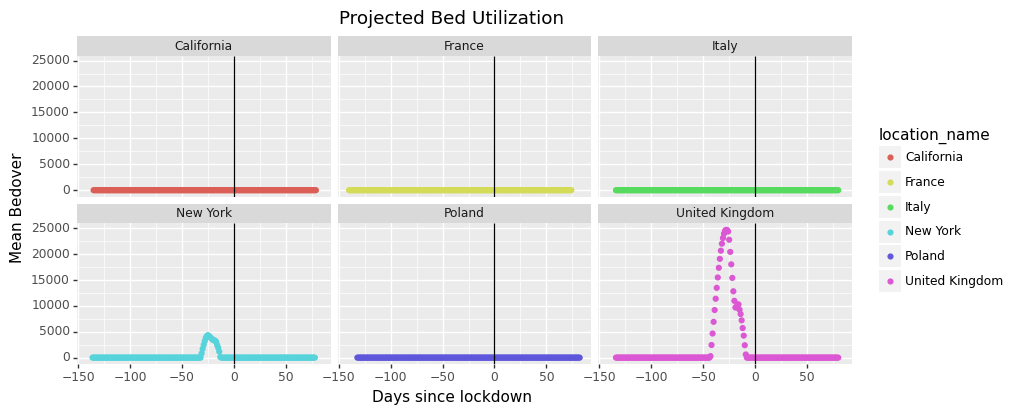

<ggplot: (-9223372036528470384)>

In [10]:
plotnine.options.figure_size = (10,4)
(ggplot(infections_df, aes('days_from_lockdown', 'bedover_mean', color='location_name'))
 + geom_point()
 + facet_wrap('~location_name')
 + geom_vline(xintercept=0)
 + labs(x='Days since lockdown',  y='Mean Bedover', title='Projected Bed Utilization')
)

### Mean Beds needed for Covid cases



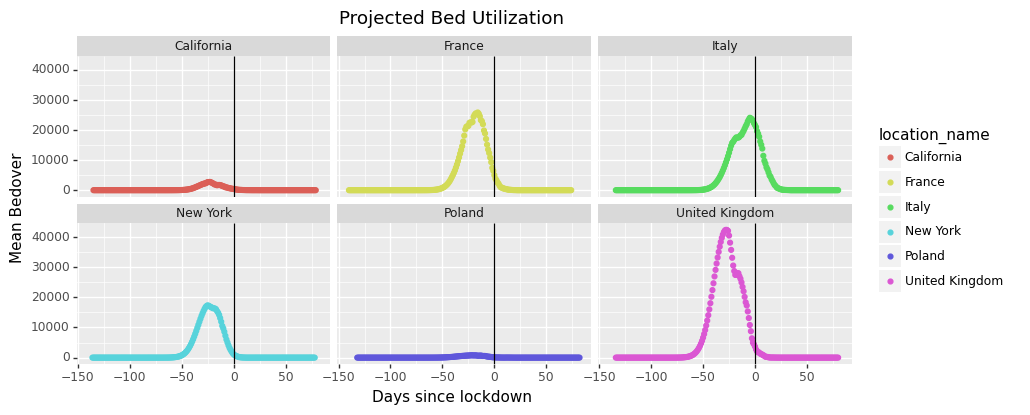

<ggplot: (-9223372036528189580)>

In [11]:
plotnine.options.figure_size = (10,4)
(ggplot(infections_df, aes('days_from_lockdown', 'allbed_mean', color='location_name'))
   + geom_point()
   + facet_wrap('~location_name')
   + geom_vline(xintercept=0)
   + labs(x='Days since lockdown',  y='Mean Bedover', title='Projected Bed Utilization')
)

### Infection Rate



**TODO** Need to edit calculation where little or no data



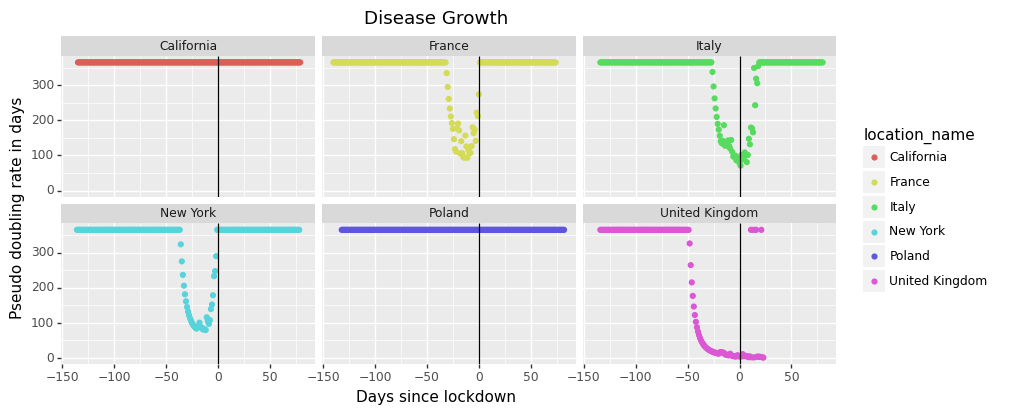

<ggplot: (-9223372036527859291)>

In [12]:
plotnine.options.figure_size = (10,4)
(ggplot(infections_df, aes('days_from_lockdown', 'progression', color='location_name'))
   + geom_point()
   + facet_wrap('~location_name')
   + geom_vline(xintercept=0)
   + labs(x='Days since lockdown',  y='Pseudo doubling rate in days', title='Disease Growth' )
)

## Model



**Approach**

*Simple Model* The decision to end a lockdown is considered every days
from the initial order. The average hospital admissions across the
previous weeks are considered. As the number of Covid-related hospital
admissions decreases, the likelihood of suspending the lockdown
increases.

*Conditions to consider adding*

-   deaths (relative to population)
-   deaths (realtive to infected)
-   ratio of recovery to newly infected
-   % of population has been tested > threshold
-   complex priors over dates (1st and 15th of month more likely. Perhaps
    Holiday's)?
-   depletion of susceptible stock 1 - (Infected + Recovered + Deaths) /
    population > threshold

*Ad-Hoc High-level features to include*

-   Government Market Orientation
-   Government Goal &#x2014; Signaling Action | Spread Mitigation

Model



In [0]:
def model(area: Area, data: pd.core.frame.DataFrame):
  # make sure reasonable things were passed in
  if not "location_name" in data:
    print(f'The data does not have the expected structure')
    raise Exception("bad data")
  elif not area.get("data_key") in data["location_name"].values:
    print(f'There is currently no infection data for {area["data_key"]}')
    raise Exception("no data")
  elif not area.get("start"):
        print(f'There is currently no lockdown for {area["data_key"]}')
        raise Exception("no lockdown")

  # model start
  area_data = data.loc[data["location_name"] == area.get("data_key")] # get data for area
  lockdown_duration = 0
  last_period_spread_rate = max(area_data['admis_mean'])
  while True:
    lockdown_duration += 1
    if (max(area_data['days_from_lockdown']) >= lockdown_duration): # keep using last infection_spread_rate if we run out of data (this is a bad hack)
      # take the average of the hospital admissions for the past five weeks
      infection_spread_rate = np.mean(area_data.loc[(area_data['days_from_lockdown'] > lockdown_duration - 35 ) &
                                                    (area_data['days_from_lockdown'] <= lockdown_duration), 'admis_mean'])

    # This logistic distribution gives the highest probability at 0 and decreases the larger the passed in value. The speed in which the probability drops off is modulated by the scale parameter. The lower the scale parameter, the lower probability assigned to high numbers. Here the .5 indicates a rather thin tail with a strong bias towards low numbers. 
    stop_quarantine = ergo.flip(scipy.stats.logistic.pdf(infection_spread_rate, scale = .5))
    last_period_spread_rate = infection_spread_rate 
    if(stop_quarantine):
        break

  ergo.tag(torch.Tensor([lockdown_duration]), area.get("data_key"))

Run Model



In [42]:
samples = pd.DataFrame() #unconditioned

for question in questions:
 samples[question.name] = ergo.run(lambda: model(get_assumptions(question), infections_df), num_samples=1500).iloc[:,0]

100%|██████████| 1500/1500 [02:29<00:00, 10.05it/s]


We calculated the model in terms of duration in days. Let's convert that to date format



In [44]:
for question in questions:
   if question.name in samples:
     start_date = get_assumptions(question)["start"]
     samples[question.name] = samples[question.name].apply(lambda x: start_date + timedelta(days=x))


TypeError: ignored

# Evaluate Models


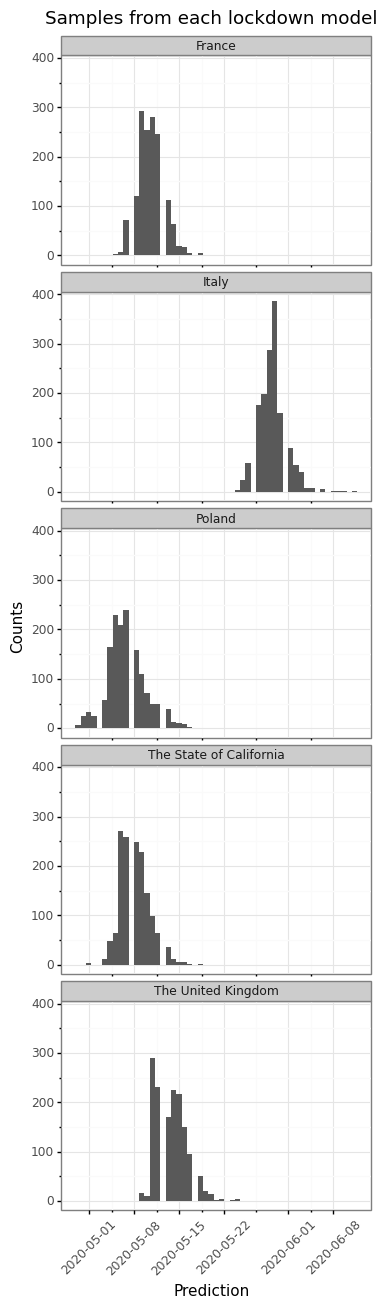

<ggplot: (327877482)>

In [47]:
plotnine.options.figure_size = (4,15)
model_samples = pd.melt(samples, var_name="questions", value_name="samples")
(ggplot(model_samples, aes("samples"))
                + geom_histogram()
                + facet_wrap('questions', ncol=1)
                + scale_x_datetime()
                + labs(
                    x="Prediction",
                    y="Counts",
                    title=f"Samples from each lockdown model"
                )
                + theme_bw() 
                + theme(axis_text_x=element_text(rotation=45, hjust=.5))
) 

## Submit Predictions



In [0]:
french_submission = questions[0].get_submission_from_samples(samples['France'])

In [50]:
french_submission

SubmissionMixtureParams(components=[SubmissionLogisticParams(loc=0.064676605, scale=0.01, low=0, high=0.99), SubmissionLogisticParams(loc=0.6860495, scale=0.59027994, low=0, high=0.6299184783604231), SubmissionLogisticParams(loc=0.6441383, scale=0.5642061, low=0, high=0.6526549671331925)], probs=[0.69878685, 0.14990684, 0.15130633])

### Compare Potential Submission to the Community's Predictions



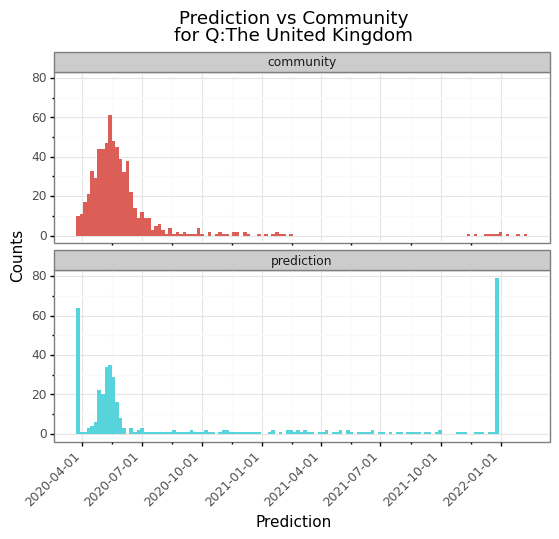

<ggplot: (-9223372036527089492)>


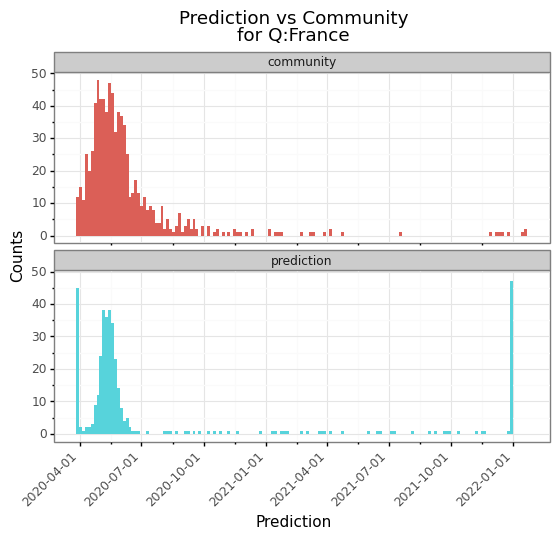

<ggplot: (332664987)>


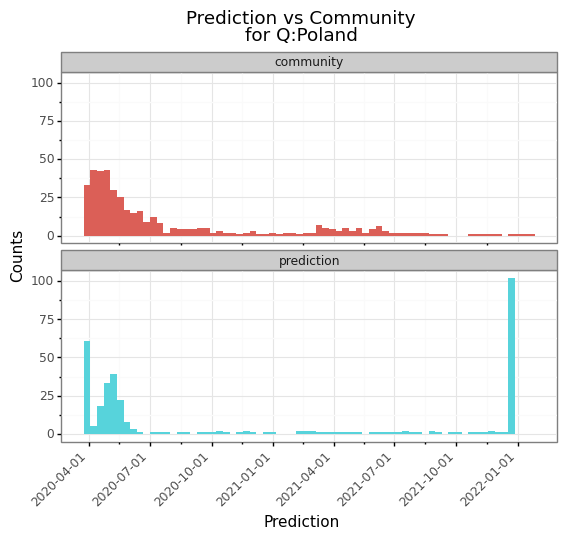

<ggplot: (333543502)>


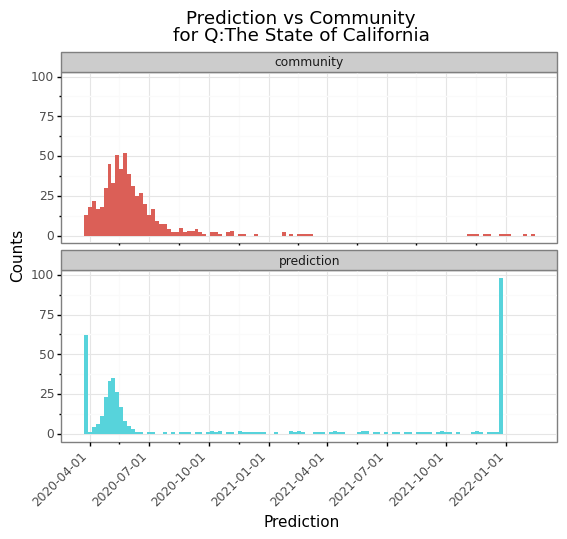

<ggplot: (333765482)>


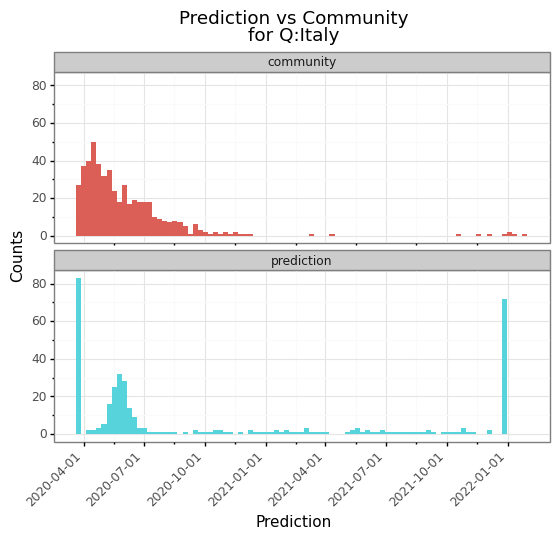

<ggplot: (326943110)>


In [48]:
for question in questions:
    if question.name in samples:
        print(question.show_submission(samples[question.name], show_community=True))

### Submit from sample



In [0]:
def submit_all():
  for question in questions:
    if question.name in samples:
      try:
        params = question.submit_from_samples(samples[question.name])
        print(f"Submitted Logistic{params} for {question.name}")
        print(f"https://pandemic.metaculus.com{question.page_url}")
      except requests.exceptions.HTTPError as e:
        print(f"Couldn't make prediction for {question.name} -- maybe this question is now closed? See error below.")
        print(e)
    else:
      print(f"No predictions for {question.name}")

Submit it!



In [0]:
#submit_all()